# data-discovery

The purpose of this notebook will be to answer several important questions about our data set, which must be answered before we start build any models.

Those questions include:
- What assumptions can we make about the data?
- What is the quality of the data, and if the quality is low, what can we do about it?
- What are the data types?
- What does the data look and feel like?
- Should any features be removed before they are ingested into our models into our models?

### install dependancies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

### what we know about the data

Lets go over everything we know about the data set, before we even load it into our notebook.

What we know about the dataset given the description on Kaggle:
- transactions occurred over two days
- the dataset has already been labeled
- dataset is highly unbalanced 
- positive class accounts for 0.172% of the data
- all fields except for time, amount, and class have been anonymized and subject to PCA analysis

### assumptions that can be made about the data set

Now, let's in addition to what we know, what reasonable assumptions can we make about the data set, before we even load it?

My first assumption with any fraud data set, is that it will be highly imbalanced in favor the negative class. For this data set that is not an assumption, but known because the data is labeled.

My second assumption with most fraud data sets, is that the data is mislabeled. From experience, I assume that most labeled fraud data sets contain false negatives. Supervised fraud models are dependant on some preliminary method of detecting fraud and in most cases these methods will miss some fraud attempts. However, for the purposes of this exercise, and the limits of what we can accomplish with a data set that has already undergone PCA, we will assume that the labelling is correct.

My next assumption will be that the PCA transformation can be trusted for this dataset. For the purposes of this analysis we will assume that the before the PCA was conducted, the data quality was high, and the analysis was done well. I am going to assume this because analyzing the quality of the PCA analysis is not part of my goal for this exercise. Furthermore, we will perform additional checks and analysis on the PCA components that will to some degree ensure the PCA analysis was done properly. 

Now, let's load in that data...

## read in the data

Let's read in our data from the creditcard.parquet file in the data folder. The original .csv has been reformatted to specify data types and reduce the size of the file. The code that was used to do this is included in the scripts folder. 

In [2]:
# read in data from parquet
cc = pd.read_parquet('../data/creditcard.parquet')

# display a few rows of the data frame
display(cc)

,class,time,amount,v1,v2,v3,v4,v5,v6,v7,...,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28
0,False,0,149.619995,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,False,0,2.690000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,False,1,378.660004,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,False,1,123.500000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,False,2,69.989998,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,...,0.803487,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,False,172786,0.770000,-11.881118,10.071785,-9.834784,-2.066656,-5.364473,-2.606837,-4.918215,...,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731
284803,False,172787,24.790001,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,...,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527
284804,False,172788,67.879997,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,...,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561
284805,False,172788,10.000000,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,...,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533


### null values, data types, and distinct values

There are three things I normally want to now first about any data set I'm analyzing.

- null values
    - how many elements in a column are null, NaN, empty
- data types
    - specifically, I want to know if the data is categorical or numeric
    - this will have a large impact on the model chosen, especially with regard to the dependant variable
- distinct values
    - how many distinct values are there for each field

In [3]:
# dispay the null counts and data types
display(cc.info())

# get number of distnit values
distinct_values = cc.nunique()
display(distinct_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   class   284807 non-null  bool   
 1   time    284807 non-null  int32  
 2   amount  284807 non-null  float32
 3   v1      284807 non-null  float32
 4   v2      284807 non-null  float32
 5   v3      284807 non-null  float32
 6   v4      284807 non-null  float32
 7   v5      284807 non-null  float32
 8   v6      284807 non-null  float32
 9   v7      284807 non-null  float32
 10  v8      284807 non-null  float32
 11  v9      284807 non-null  float32
 12  v10     284807 non-null  float32
 13  v11     284807 non-null  float32
 14  v12     284807 non-null  float32
 15  v13     284807 non-null  float32
 16  v14     284807 non-null  float32
 17  v15     284807 non-null  float32
 18  v16     284807 non-null  float32
 19  v17     284807 non-null  float32
 20  v18     284807 non-null  float32
 21  v19     28

None

class          2
time      124592
amount     32767
v1        274338
v2        275163
v3        275081
v4        275143
v5        275223
v6        275092
v7        275182
v8        275244
v9        275208
v10       275175
v11       275043
v12       275162
v13       275167
v14       275238
v15       275134
v16       275149
v17       275148
v18       275208
v19       275185
v20       275185
v21       275170
v22       275096
v23       275186
v24       275113
v25       275091
v26       275146
v27       275295
v28       275249
dtype: int64

This data set has every value populated throughout the table. All of our dependant variables are numeric, and our dependant variable is binomial. And all of the numeric fields have high number of distinct values, although some are higher than others. 

The conclusions I can draw so far are that potentially every field will be of interest here and should be included in whichever model we end up choosing. A lack of null values and a high number of distinct values indicates that the data is a good candidate for quantitative analysis and is an indicator of high data quality. When fields have excessive number of null values, or very few distinct values, it is often an early indicator that they should be thrown out. In our case (which is a condition I rarely find myself in) it looks like we may not have to throw out any of the data or go into extensive tests to determine the quality of the data.

## analysis of individual fields

Now that we have looked at for null elements, data types, and distinct values, lets dig into the individual fields. It is already obvious that that our data is going to fall into 3 buckets. 
1. the fraud class
2. the time and amount fields
    - numeric fields that will likely each have their own shape and feel
3. the PCA components
    - numeric fields that will be significant to our analysis, but will likely have a similar shape and feel (although we will confirm that assupmtion)

### class

Let's get to know our target variable a little bit better.

In [4]:
# display counts of each distinct value of class
class_counts = cc['class'].value_counts()

print(class_counts)

# calcualte percentage of each class
class_counts = cc['class'].value_counts(normalize=True)
print()

# print class_counts as percentages
print("class Percenages")
print(f"0\t{class_counts.iloc[0]:.10%}")
print(f"0\t{class_counts.iloc[1]:.10%}")

class
False    284315
True        492
Name: count, dtype: int64

class Percenages
0	99.8272514369%
0	0.1727485631%


Indeed we have verified the statement on Kaggle that less than one fifth of one percent of the data is in the positive class. And on that note, there is not much more we can analyze looking at a binomial field in isolation. But don't worry, we will come back to issue of class imbalance many more times.

### amount & time

Let's generate some descriptive stats and visualizations to understand the look and feel of the two un-anonymized input fields.

In [5]:
# summary stats for time and amount
cc_time_amount_class = cc[['amount', 'time']]
summary_stats = cc_time_amount_class.describe()

display(summary_stats)

,amount,time
count,284807.000000,284807.000000
mean,88.349609,94813.859575
std,250.120117,47488.145955
min,0.000000,0.000000
25%,5.600000,54201.500000
50%,22.000000,84692.000000
75%,77.165001,139320.500000
max,25691.160156,172792.000000


My absolute favorite plot, is the violin plot. It displays your mean, your quartiles, your outliers, and in my opinion there is not better plot to gain a quick understand of the general nature of a field. Unfortunately for the amount field the plot is not very interesting, other than telling us we have some extreme outliers on the upper end.

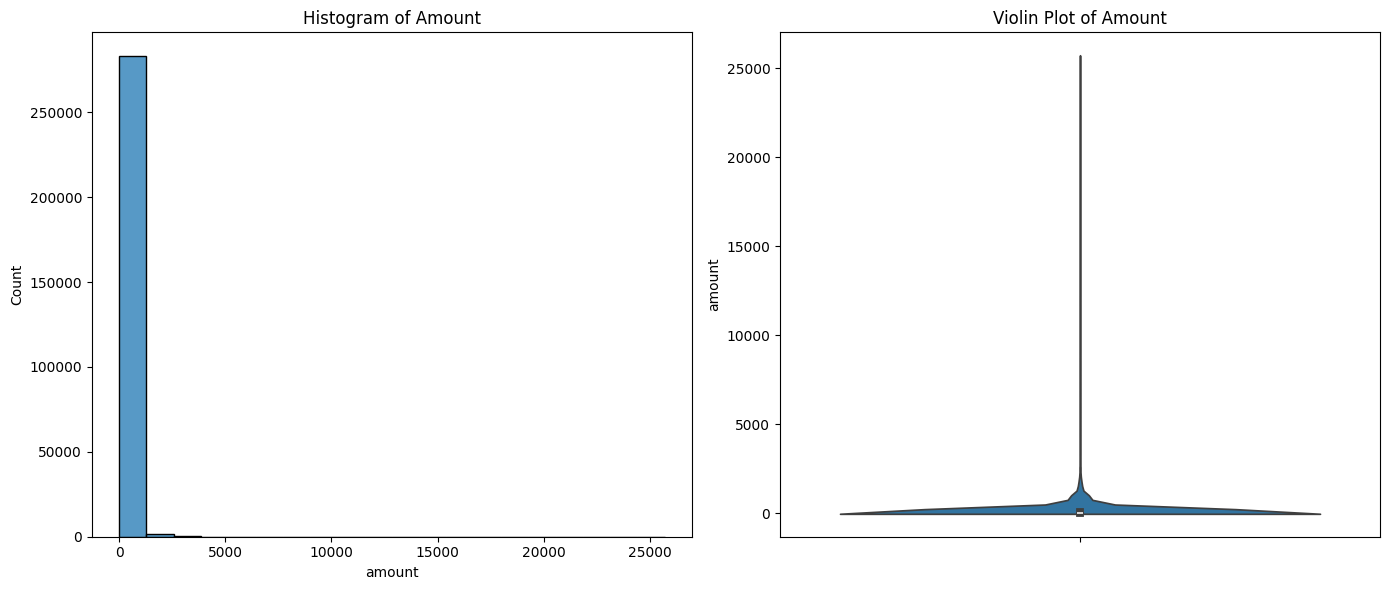

In [6]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot time on histogram
sns.histplot(cc['amount'], bins=20, ax=axes[0])
axes[0].set_title('Histogram of Amount')

# Plot time on violin plot
sns.violinplot(y=cc['amount'], ax=axes[1])
axes[1].set_title('Violin Plot of Amount')

# Display the plots
plt.tight_layout()
plt.show()

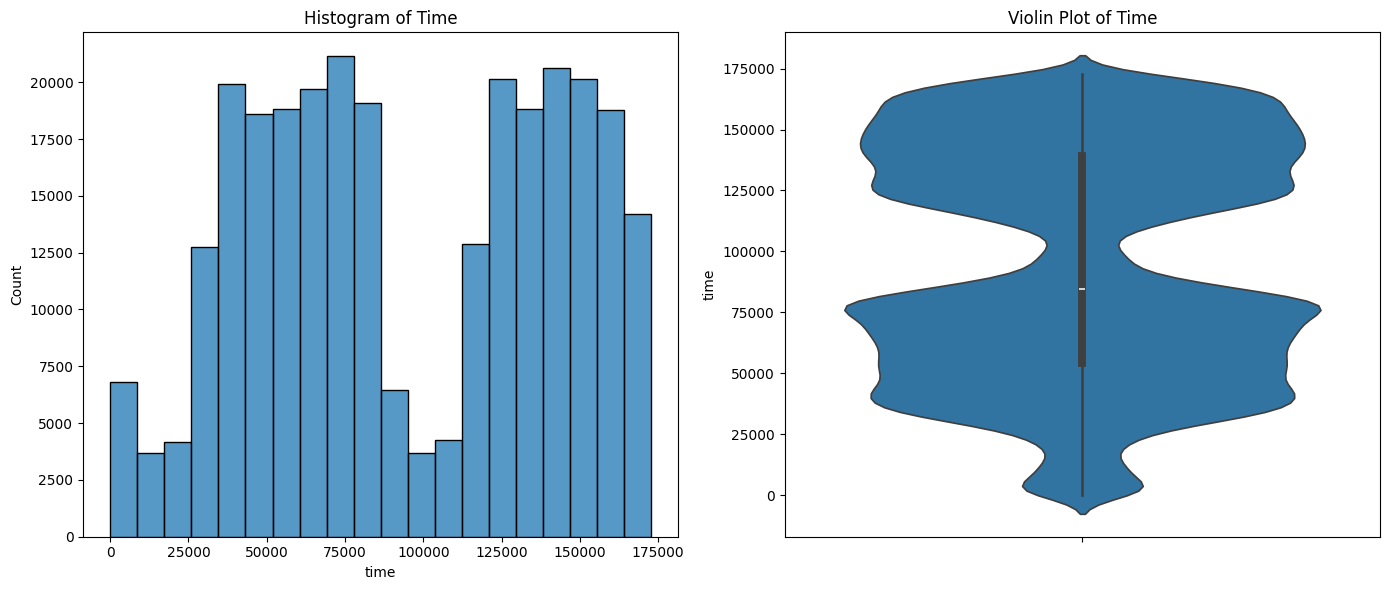

In [7]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot time on histogram
sns.histplot(cc['time'], bins=20, ax=axes[0])
axes[0].set_title('Histogram of Time')

# Plot time on violin plot
sns.violinplot(y=cc['time'], ax=axes[1])
axes[1].set_title('Violin Plot of Time')

# Display the plots
plt.tight_layout()
plt.show()

We can see that the amount field has a very long right tail, and we can also see some obvious patterns in the number of transactions over time. We can also see (if we scroll down just a little bit, and then come back to here) that the the averages and upper limits of the time and amount fields are much greater than for any of the PCA components. Also, the fact that there are some various obvious patterns in the time field make it ripe for generating additional fields from it's current form, which is number of seconds elapsed since the first transaction. We will take these insights into our next notebook, which will cover feature generation.

### PCA components

We can that our assumption that all of the PCA components will display relatively similar behavior is indeed true. All have highly normal distributions, with most have their 1st and 3rd quartiles between -5 and 5. There are some large outliers, although almost every field has min/max values between -100/100. 

From this information I conclude that all of the PCA components should be included in our models. Also, because they have highly normalized distributions, similar magnitudes, and the data has already undergone a dimensionality reduction transformation, I do not belive any additional pre-processing or feature engineering will be needed for this fields.

We will not generate some basic statistics for all of the PCA components. We will arbitrarily break them into groups, due to the limitations of how many visualizations we can combine into one plot.

In [8]:
# fucntion to display slices of the PCA compoents
def display_pca(cc_slice):
    summary_stats = cc_slice.describe()
    display(summary_stats)

    # display historgram
    fig, axes = plt.subplots(1, 7, figsize=(20, 5))
    for i, col in enumerate(cc_slice.columns):
        sns.histplot(cc_slice[col].dropna(), ax=axes[i], bins=20)  
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

    # display violing plots
    plt.figure(figsize=(14, 6)) 
    sns.violinplot(data=cc_slice)
    plt.show()

,v1,v2,v3,v4,v5,v6,v7
count,2.848070e+05,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,1.339397e-08,0.000000,-4.800400e-08,6.643411e-09,2.657364e-08,-1.500125e-09,-1.071518e-09
std,1.958696e+00,1.651309,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00
min,-5.640751e+01,-72.715729,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01
25%,-9.203734e-01,-0.598550,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01
50%,1.810880e-02,0.065486,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02
75%,1.315642e+00,0.803724,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01
max,2.454930e+00,22.057730,9.382559e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02


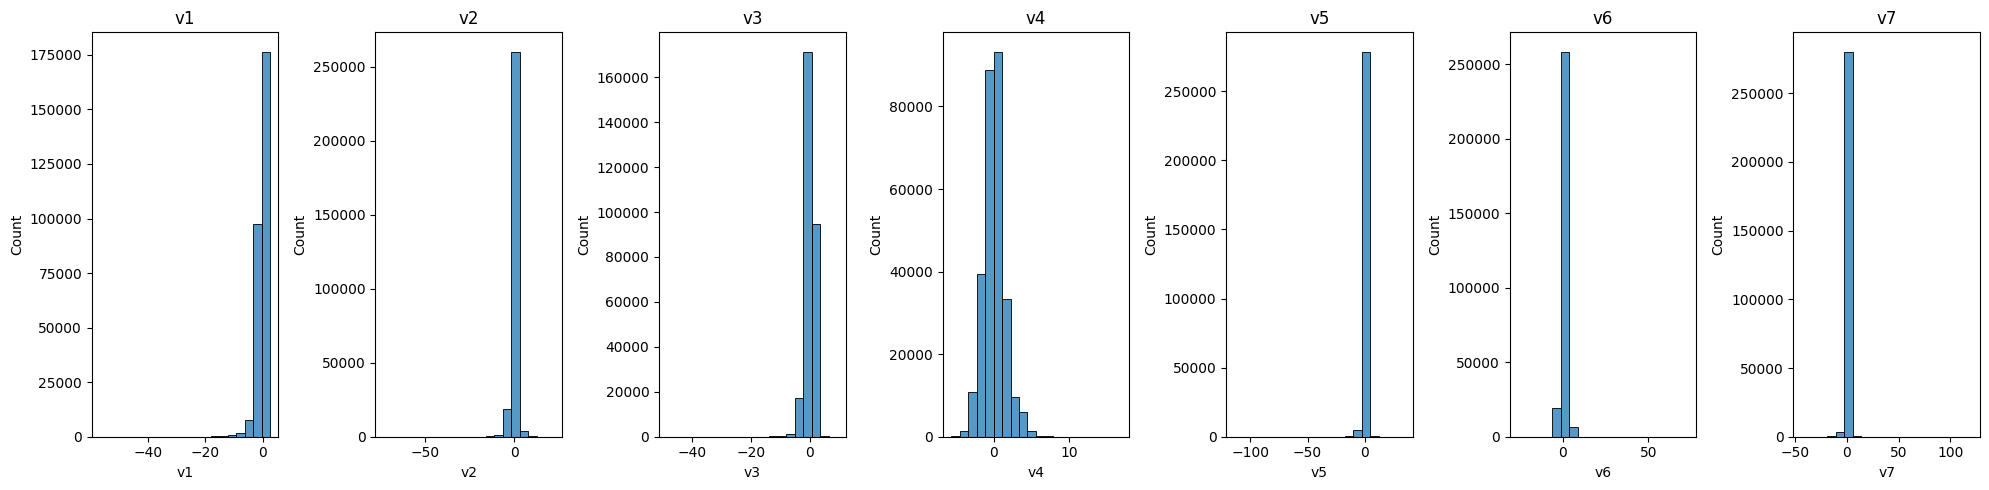

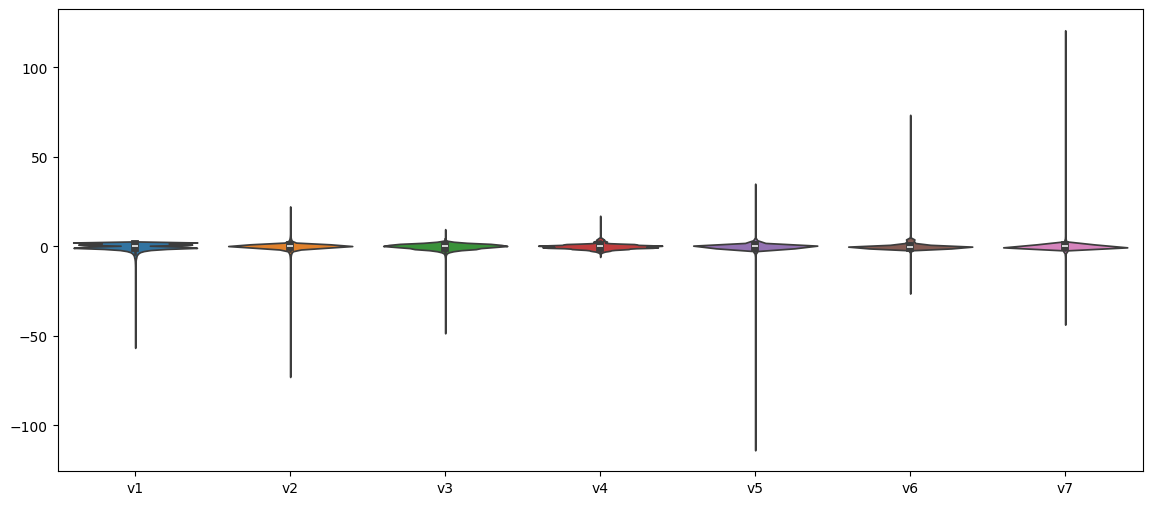

In [9]:
# get summary features
display_pca(cc[['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7']])

,v8,v9,v10,v11,v12,v13,v14
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.071518e-10,-3.214554e-10,-4.071768e-09,7.714928e-09,8.572143e-09,1.580489e-09,-3.107402e-09
std,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01
min,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921432e+01
25%,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01
50%,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02
75%,3.273458e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01
max,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01


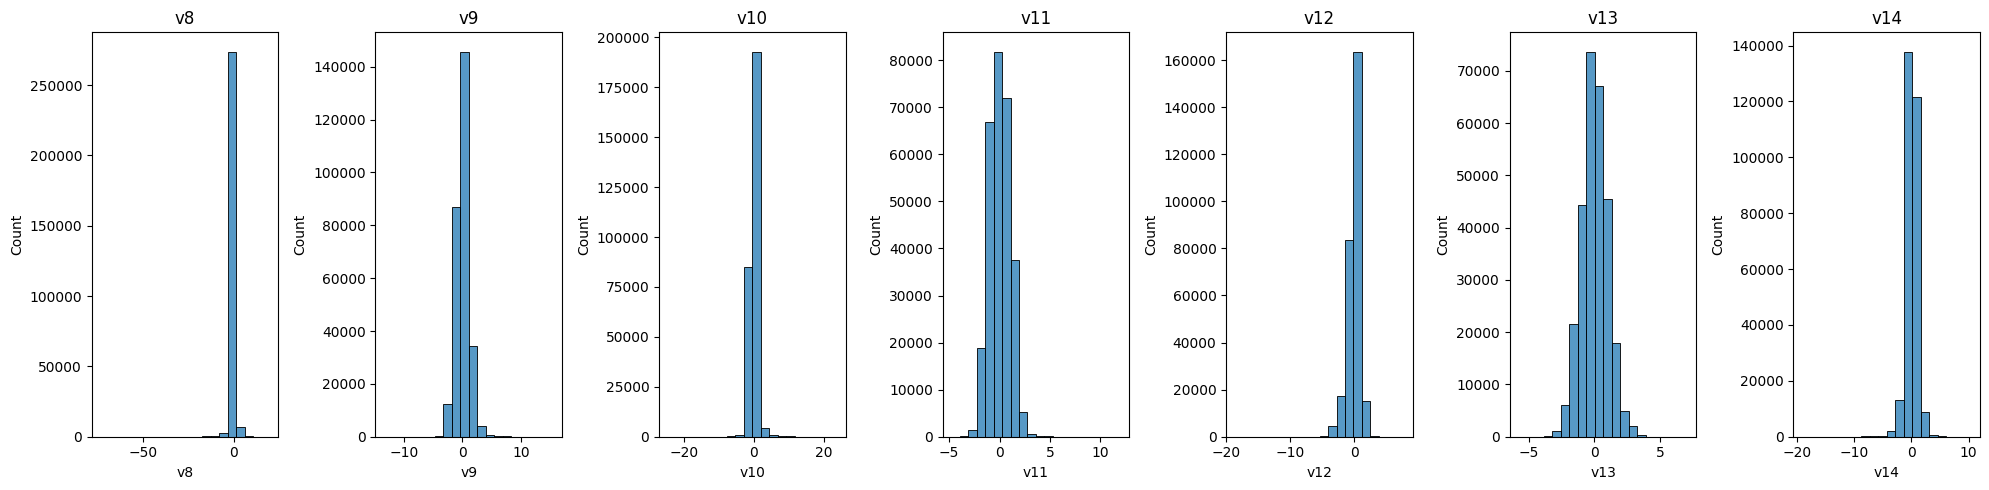

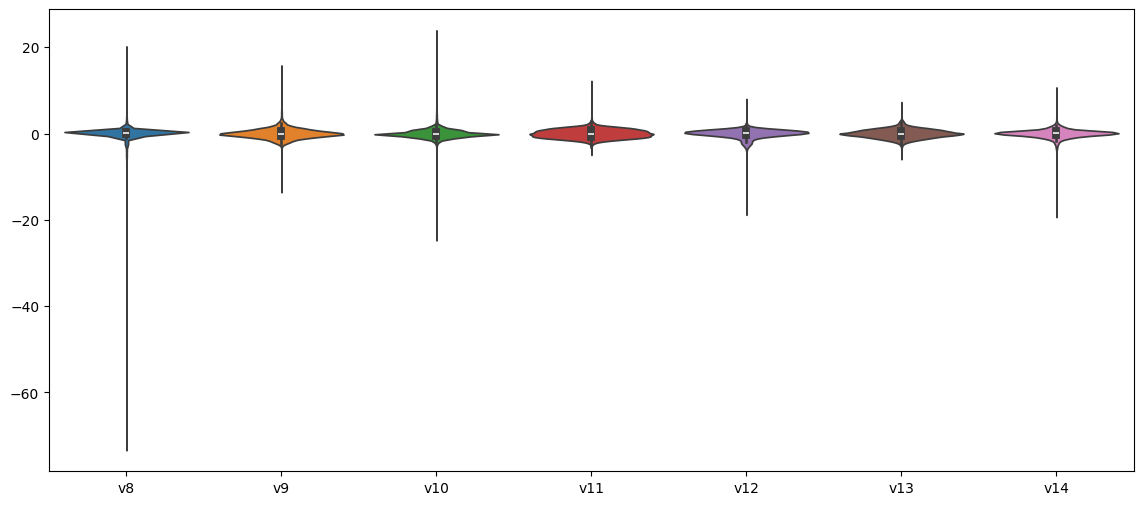

In [10]:
display_pca(cc[['v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14']])

,v15,v16,v17,v18,v19,v20,v21
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.285821e-08,7.500625e-10,-2.625219e-09,2.357339e-09,2.678795e-10,-1.178670e-09,-1.928732e-09
std,9.153160e-01,8.762529e-01,8.493370e-01,8.381763e-01,8.140405e-01,7.709250e-01,7.345240e-01
min,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01
25%,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01
50%,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02
75%,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589493e-01,1.330408e-01,1.863772e-01
max,8.877742e+00,1.731511e+01,9.253527e+00,5.041069e+00,5.591971e+00,3.942091e+01,2.720284e+01


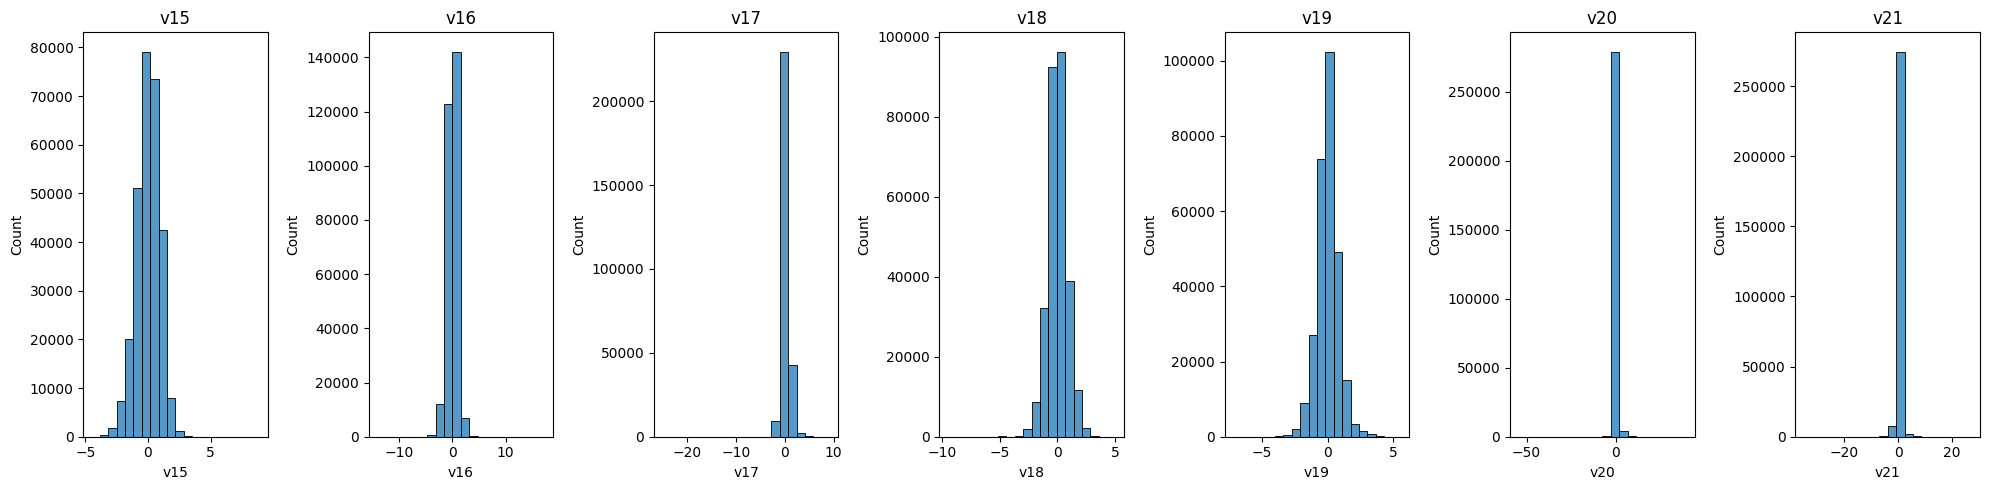

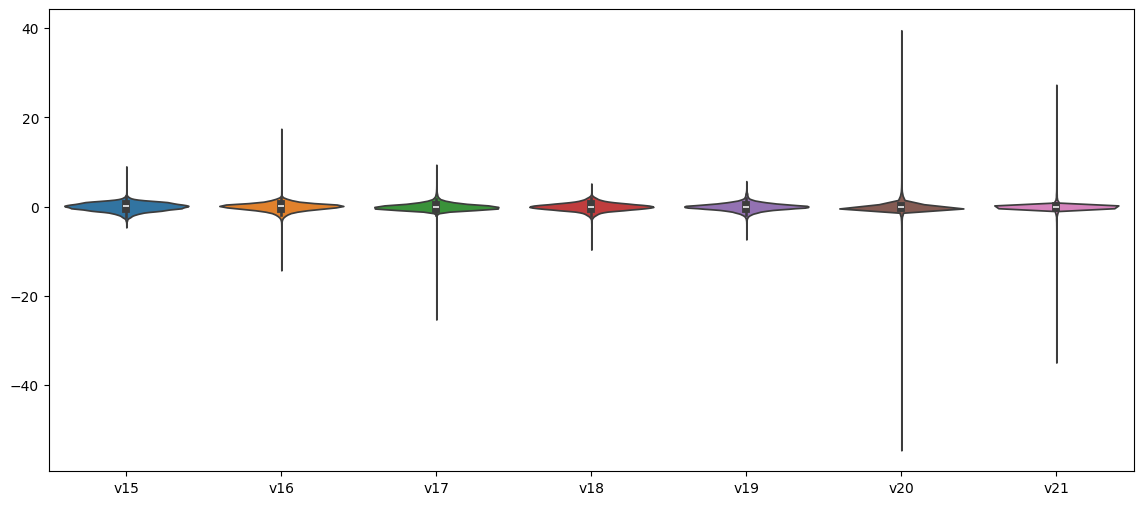

In [11]:
display_pca(cc[['v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21']])

,v22,v23,v24,v25,v26,v27,v28
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,3.643161e-09,3.214554e-10,1.259033e-09,2.143036e-09,1.034684e-09,1.138488e-10,-1.272427e-10
std,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01
min,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01
25%,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02
50%,6.781943e-03,-1.119293e-02,4.097605e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02
75%,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02
max,1.050309e+01,2.252841e+01,4.584549e+00,7.519588e+00,3.517346e+00,3.161220e+01,3.384781e+01


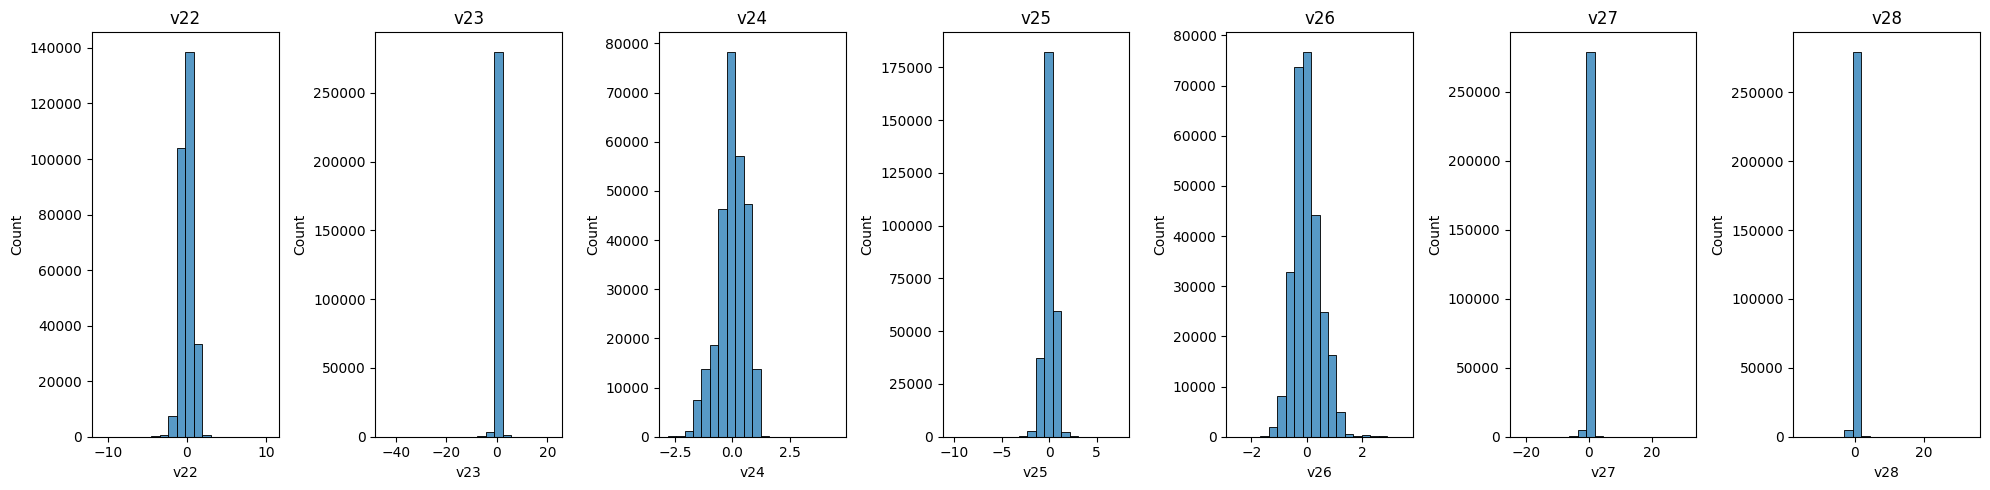

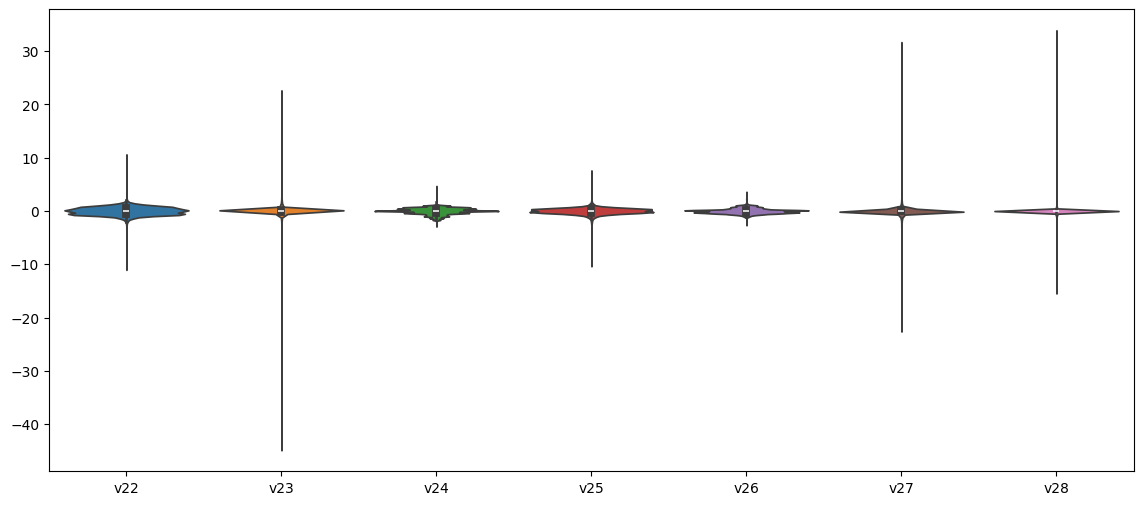

In [12]:
display_pca(cc[['v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28']])

## inter-field relationships

Now let's a little bit of analysis on the relationships between the fields.

### Pearson Correlation Coefficient Matrix

Lets look at the linear correlations between all of our variables.

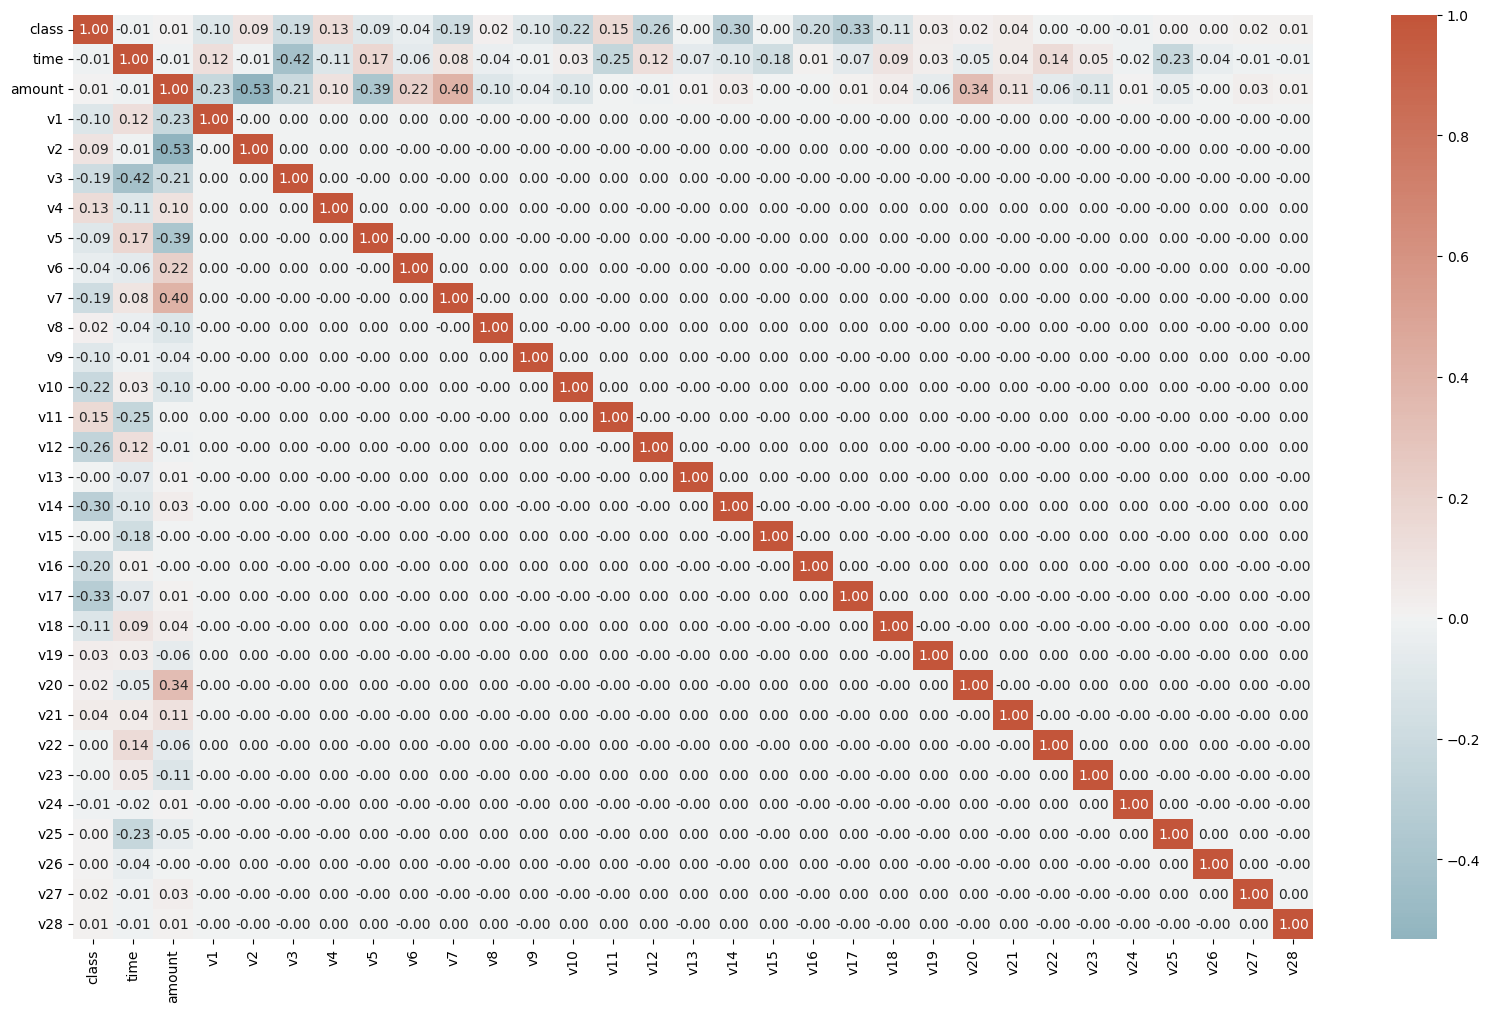

In [13]:
# plot correlation matrix
plt.figure(figsize=(20, 12))

# Create a custom colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the heatmap with the custom colormap
sns.heatmap(cc.corr(), annot=True, cmap=cmap, center=0, fmt=".2f")

# Display the plot
plt.show()

From the correlation we can tell a couple of things. First, the PCA components are completely uncorrelated. This give more evidence to our original assumption that the PCA was done well and can be trusted.

Next, we see that time and amount actually have almost no correlation whatsoever with the target class. However, there are multiple of the PCA components do have some meaningful correlations with the target class.

If this were a much larger dataset and we were under compute constraints, the fact that multiple of the PCA components show almost no correlation with the target, might be an early indicator that they should be thrown out. However, the correlation matrix above only shows linear relationships, and some of the models we will test will look for non-linear relationships as well interaction effects. Additionally, although some of the PCA components show high collinearity with the amount and time field, anything below a value of 0.75 shouldn't cause any significant issues with any of the models we are going to test. 

### highly correlated features

The last thing we are going to do in this notebook is to visualize the relationships between the features that have obviously high correlations with the target class. Specifically we are going to look at the 4 features with the highest absolute correlation with the taret class: v17, v14, v12v, and v10.

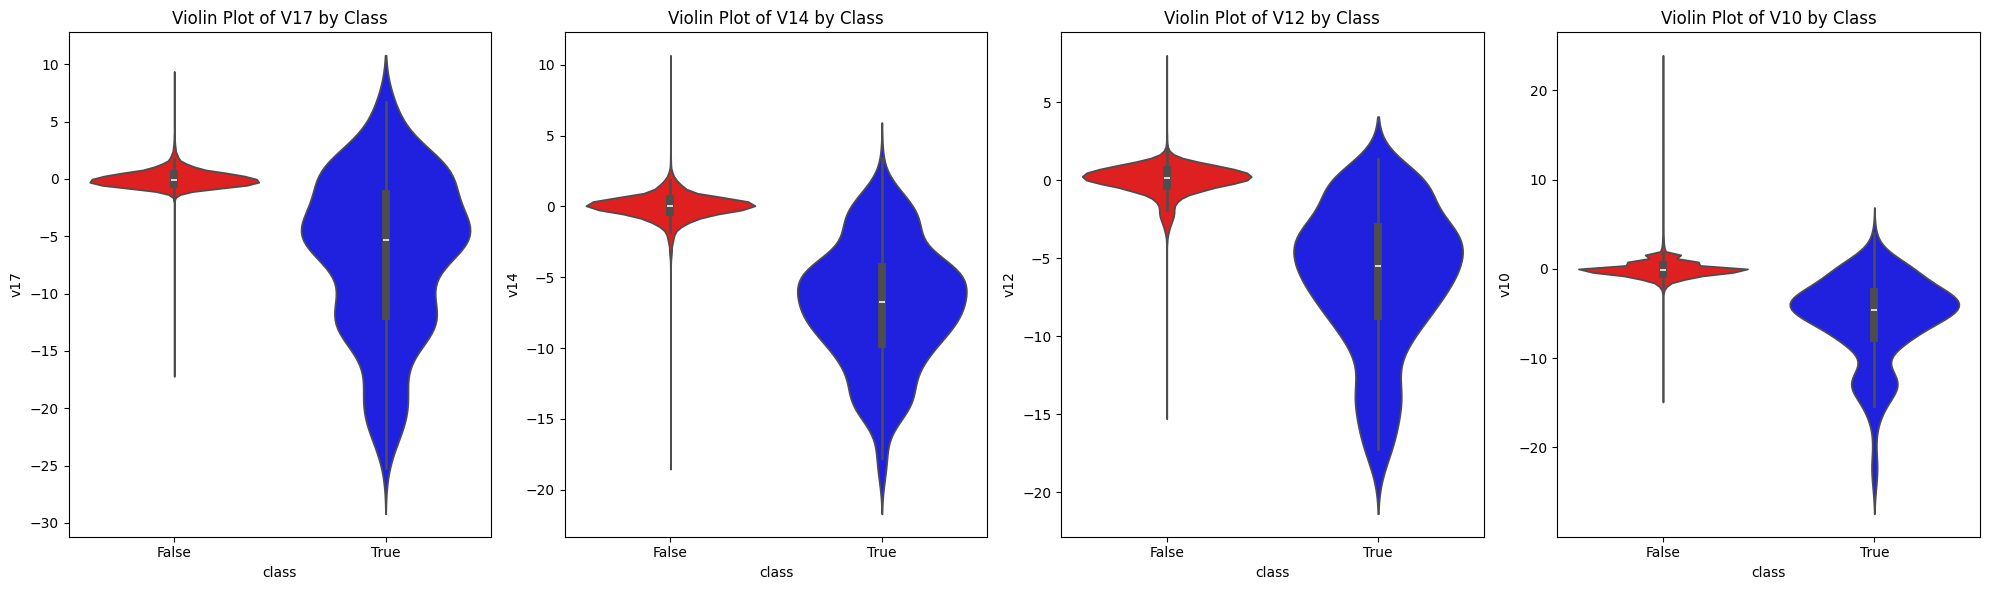

In [14]:
# Create a figure with four subplots side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Define the colors for the classes
palette = {False: 'red', True: 'blue'}

# Plot v17
sns.violinplot(x='class', y='v17', data=cc, ax=axes[0], hue='class', palette=palette)
axes[0].set_title('Violin Plot of V17 by Class')
axes[0].get_legend().remove()

# Plot v14
sns.violinplot(x='class', y='v14', data=cc, ax=axes[1], hue='class', palette=palette)
axes[1].set_title('Violin Plot of V14 by Class')
axes[1].get_legend().remove()

# Plot v12
sns.violinplot(x='class', y='v12', data=cc, ax=axes[2], hue='class', palette=palette)
axes[2].set_title('Violin Plot of V12 by Class')
axes[2].get_legend().remove()

# Plot v10
sns.violinplot(x='class', y='v10', data=cc, ax=axes[3], hue='class', palette=palette)
axes[3].set_title('Violin Plot of V10 by Class')
axes[3].get_legend().remove()

# Adjust layout
plt.tight_layout()
plt.show()

## conclusions

Let's wrap up our observations before we move on to feature generation.
- we have confirmed that the fraud class is highly imbalanced
- we are going to keep all of the data for our models
    - all features contains no null values
    - all features contain a high degree of uniqueness
    - the distributions of all features look realistic when visualized, and do not show any cause for alarm
    - all features are not overly collinear
- the PCA components do not need further feature generation
    - they are all highly normalized and have similar magnitudes
    - they have already undergone PCA analysis
    - we have seen evidence to prove that the PCA analysis can be trusted
- the amount and time may need some additional pre-processing and feature generation
    - these fields are of significantly higher absolute magnitude than the PCA components
    - these fields show patterns that may be more valuable for the model to ingest if further broken down

And with that I will move on the notebook 02-feature-engineering .
